In [25]:
# Import dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from kerastuner.tuners import RandomSearch
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf

In [2]:
# import data
df = pd.read_csv("../resources/ames_housing_data.csv")
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
# display numerical features
df_num = df.select_dtypes(include=["float64", "int64"])
df_num.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,1,60,65.0,8450,7,5,2003,2003,196.0,706,...,0,61,0,0,0,0,0,2,2008,208500
1,2,20,80.0,9600,6,8,1976,1976,0.0,978,...,298,0,0,0,0,0,0,5,2007,181500
2,3,60,68.0,11250,7,5,2001,2002,162.0,486,...,0,42,0,0,0,0,0,9,2008,223500
3,4,70,60.0,9550,7,5,1915,1970,0.0,216,...,0,35,272,0,0,0,0,2,2006,140000
4,5,60,84.0,14260,8,5,2000,2000,350.0,655,...,192,84,0,0,0,0,0,12,2008,250000


## Data Preprocessing

In [4]:
# fill missing values with the mean for each numerical feature
df = df.fillna(df_num.mean())

In [5]:
# drop 'Id'
df = df.drop("Id", axis=1)
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [6]:
# drop outliers (rooms with more than 4000 square feet)
df = df[df.GrLivArea <= 4000]

In [7]:
# get_dummies for categorical data
dummies = pd.get_dummies(df)
dummies.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,60,65.0,8450,7,5,2003,2003,196.0,706,0,...,False,False,False,True,False,False,False,False,True,False
1,20,80.0,9600,6,8,1976,1976,0.0,978,0,...,False,False,False,True,False,False,False,False,True,False
2,60,68.0,11250,7,5,2001,2002,162.0,486,0,...,False,False,False,True,False,False,False,False,True,False
3,70,60.0,9550,7,5,1915,1970,0.0,216,0,...,False,False,False,True,True,False,False,False,False,False
4,60,84.0,14260,8,5,2000,2000,350.0,655,0,...,False,False,False,True,False,False,False,False,True,False


In [8]:
# split data into target and features
y = dummies.SalePrice.values
X = dummies.drop(columns="SalePrice").values

# split data into training, testing, and validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(
    X_test, y_test, test_size=0.5, random_state=42
)

# scale the data
scaler = StandardScaler()

# fit the scaler only to the training data
# to prevent data leakage (e.g., mean and standard deviation not modified by X_test and X_val)
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

# df just to plot the data immediately below
# scaled_df = pd.DataFrame(X_scaled, columns=dummies.drop(columns="SalePrice").columns)

In [9]:
# plot data before scaling
# dummies.plot(title='Before Scaling', figsize=(10, 6))
# plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
# plt.show()

# # after scaling
# scaled_df.plot(title='After Scaling', figsize=(10, 6))
# plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
# plt.show()

## Compile, Train, Evaluate the Model

In [10]:
# build keras-tuner function
def build_model(hp):
    nn_test = tf.keras.models.Sequential()

    # adds a range of 1 to 5 dense layers, allowable number of neurons (adjust based on features), activation functions
    for i in range(hp.Int("num_layers", min_value=1, max_value=5, step=1)):
        nn_test.add(
            tf.keras.layers.Dense(
                units=hp.Int(f"layer{i}", min_value=50, max_value=600, step=50),
                input_dim=len(X_train[0]),
                activation=hp.Choice(f"activation{i}", values=["relu", "tanh", "LeakyReLU"])
            )
        )

    # add final layer
    nn_test.add(tf.keras.layers.Dense(units=1, activation="linear"))

    # compile the model
    nn_test.compile(
        loss="mean_absolute_error",
        optimizer="adam",
        metrics=["mae"],
    )

    return nn_test

In [11]:

# define tuner / call the build_model function
tuner = RandomSearch(build_model, objective="mae", max_trials=10, overwrite=True)

# run the damn thing
tuner.search(
    X_train,
    y_train,
    epochs=100,
    validation_data=(X_val, y_val),
)

Trial 10 Complete [00h 00m 23s]
mae: 108435.875

Best mae So Far: 4031.856689453125
Total elapsed time: 00h 03m 08s


In [12]:
# summary of results
tuner.results_summary()

Results summary
Results in .\untitled_project
Showing 10 best trials
Objective(name="mae", direction="min")

Trial 03 summary
Hyperparameters:
num_layers: 5
layer0: 50
activation0: relu
layer1: 600
activation1: LeakyReLU
layer2: 500
activation2: LeakyReLU
layer3: 50
activation3: relu
layer4: 50
activation4: relu
Score: 4031.856689453125

Trial 08 summary
Hyperparameters:
num_layers: 4
layer0: 50
activation0: LeakyReLU
layer1: 400
activation1: relu
layer2: 500
activation2: tanh
layer3: 150
activation3: relu
layer4: 500
activation4: relu
Score: 10971.697265625

Trial 00 summary
Hyperparameters:
num_layers: 3
layer0: 50
activation0: tanh
layer1: 50
activation1: relu
layer2: 50
activation2: relu
Score: 16453.533203125

Trial 07 summary
Hyperparameters:
num_layers: 5
layer0: 550
activation0: relu
layer1: 500
activation1: LeakyReLU
layer2: 400
activation2: LeakyReLU
layer3: 350
activation3: tanh
layer4: 300
activation4: LeakyReLU
Score: 55331.3125

Trial 09 summary
Hyperparameters:
num_layer

In [13]:
# get the best hyperparameters from the tuner
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# build that model
nn = tuner.hypermodel.build(best_hps)

# add early stopping to prevent overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=10, restore_best_weights=True
)

# train the model
fit_model = nn.fit(
    X_train,
    y_train,
    epochs=100,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping],
)

Epoch 1/100
35/35 [==============================] - 2s 11ms/step - loss: 182166.0625 - mae: 182166.0625 - val_loss: 173286.1719 - val_mae: 173286.1719
Epoch 2/100
35/35 [==============================] - 0s 5ms/step - loss: 164688.5938 - mae: 164688.5938 - val_loss: 98016.4062 - val_mae: 98016.4062
Epoch 3/100
35/35 [==============================] - 0s 5ms/step - loss: 49899.7969 - mae: 49899.7969 - val_loss: 26884.2793 - val_mae: 26884.2793
Epoch 4/100
35/35 [==============================] - 0s 5ms/step - loss: 25650.5645 - mae: 25650.5645 - val_loss: 25399.2637 - val_mae: 25399.2637
Epoch 5/100
35/35 [==============================] - 0s 5ms/step - loss: 19797.6367 - mae: 19797.6367 - val_loss: 22275.7402 - val_mae: 22275.7402
Epoch 6/100
35/35 [==============================] - 0s 5ms/step - loss: 16870.1914 - mae: 16870.1914 - val_loss: 21902.6133 - val_mae: 21902.6133
Epoch 7/100
35/35 [==============================] - 0s 5ms/step - loss: 14417.4023 - mae: 14417.4023 - val_los

In [14]:
print("Best Hyperparameters:")
print(best_hps.values)

Best Hyperparameters:
{'num_layers': 5, 'layer0': 50, 'activation0': 'relu', 'layer1': 600, 'activation1': 'LeakyReLU', 'layer2': 500, 'activation2': 'LeakyReLU', 'layer3': 50, 'activation3': 'relu', 'layer4': 50, 'activation4': 'relu'}


In [15]:
# summarize final model
nn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 50)                14350     
                                                                 
 dense_6 (Dense)             (None, 600)               30600     
                                                                 
 dense_7 (Dense)             (None, 500)               300500    
                                                                 
 dense_8 (Dense)             (None, 50)                25050     
                                                                 
 dense_9 (Dense)             (None, 50)                2550      
                                                                 
 dense_10 (Dense)            (None, 1)                 51        
                                                                 
Total params: 373101 (1.42 MB)
Trainable params: 37310

In [16]:
# print weights, just because
all_weights = nn.get_weights()
for i, layer_weights in enumerate(all_weights):
    print(f"Layer {i} Weights:")
    print(layer_weights)

Layer 0 Weights:
[[ 0.14169365 -0.14586112 -0.07333416 ... -0.15155259  0.10166597
   0.03539785]
 [-0.01746945  0.06015698  0.17158292 ... -0.0675863  -0.09154323
  -0.08160202]
 [ 0.06970907  0.14513561  0.03857869 ... -0.00561831 -0.09180877
  -0.06506308]
 ...
 [ 0.01300721  0.12263568 -0.13868883 ...  0.08863801 -0.12650284
  -0.00346675]
 [ 0.13710243 -0.15749797 -0.184148   ...  0.20049545  0.17576842
   0.21895336]
 [-0.07195277  0.15428708  0.19374187 ... -0.326899   -0.1187619
  -0.24412309]]
Layer 1 Weights:
[0.10720211 0.1082147  0.10608128 0.14437678 0.11623424 0.13892739
 0.13667363 0.13631277 0.18550958 0.14231445 0.11287288 0.09348997
 0.11187418 0.12151083 0.10832787 0.14705192 0.14417234 0.09596202
 0.10493743 0.1210281  0.11496296 0.15565185 0.12567781 0.09607194
 0.13387485 0.12631933 0.10814998 0.13684845 0.14301035 0.12843074
 0.13560453 0.07002895 0.15290074 0.16240536 0.16309452 0.14429548
 0.11091023 0.16735664 0.15394458 0.10360117 0.15230365 0.1480834
 0.1495

In [17]:
# revert scaled data for testing predictions
y_test_pred=nn.predict(X_test)

6/6 [==============================] - 0s 2ms/step


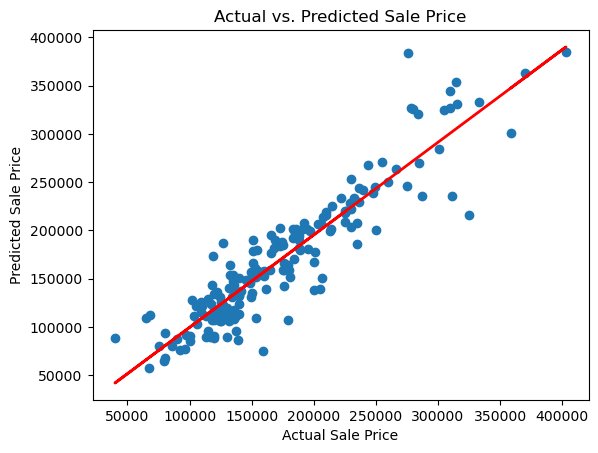

In [18]:
# Scatter plot for actual vs. predicted Sale Price
plt.scatter(y_test, y_test_pred.flatten())
plt.xlabel("Actual Sale Price")
plt.ylabel("Predicted Sale Price")
plt.title("Actual vs. Predicted Sale Price")

# Add a line of best fit
fit = np.polyfit(y_test.flatten(), y_test_pred.flatten(), 1)
line = np.poly1d(fit)
plt.plot(y_test.flatten(), line(y_test.flatten()), color="red", linewidth=2)

plt.show()

In [19]:
# print the r_squared
print(f"R-squared: {r2_score(y_test, y_test_pred)}")

# and other metrics
print(f"Mean Squared Error: {mean_squared_error(y_test, y_test_pred)}")
print(f"Mean Absolute Error: {mean_absolute_error(y_test, y_test_pred)}")
print(f"Mean Percentage Error: {np.mean((y_test - y_test_pred) / y_test) * 100}")

R-squared: 0.8344301060657537
Mean Squared Error: 718762430.5161287
Mean Absolute Error: 19201.324690934067
Mean Percentage Error: -13.073983522657496


In [20]:
# predict a baseline
# essentially, set every value to the mean and create a fake list of predictions
# compare to above model's predictions
baseline_prediction = y_train.mean()

# create array of baseline predictions with the length of y_test
baseline_predictions = [baseline_prediction] * len(y_test)

print(f"Baseline R-squared: {r2_score(y_test, baseline_predictions)}")
print(
    f"Baseline Mean Squared Error: {mean_squared_error(y_test, baseline_predictions)}"
)
print(
    f"Baseline Mean Absolute Error: {mean_absolute_error(y_test, baseline_predictions)}"
)
print(
    f"Mean Percentage Error: {np.mean((y_test - baseline_predictions) / y_test) * 100}"
)

Baseline R-squared: -0.020610114208674313
Baseline Mean Squared Error: 4430613494.197803
Baseline Mean Absolute Error: 54345.8021978022
Mean Percentage Error: -21.726878869297774


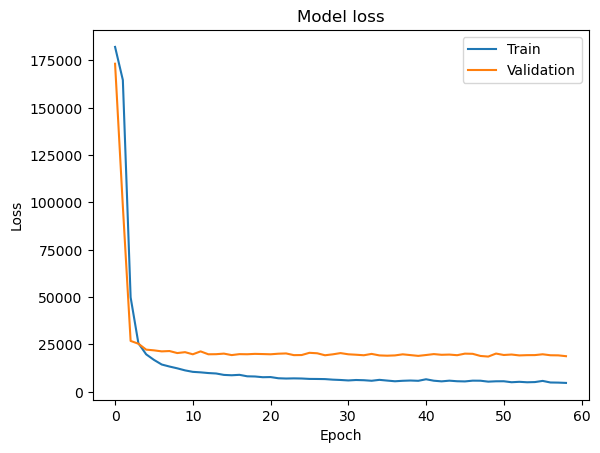

In [21]:
# plot training & validation loss values
# hopefully these both drop quickly and stabilize
# if not...
# validation loss up and training down? overfitting
# training and validation high? underfitting
plt.plot(fit_model.history["loss"])
plt.plot(fit_model.history["val_loss"])
plt.title("Model loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Train", "Validation"], loc="upper right")
plt.show()

6/6 [==============================] - 0s 2ms/step


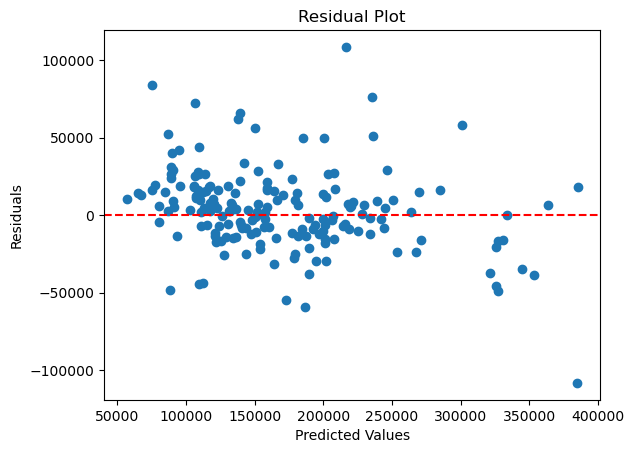

In [22]:
# residual plot
# difference between actual and predicted values
# you want there to be a rnadom distribution around the red line, zero
residuals = y_test - nn.predict(X_test).flatten()
plt.scatter(nn.predict(X_test).flatten(), residuals)
plt.axhline(y=0, color="r", linestyle="--")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()

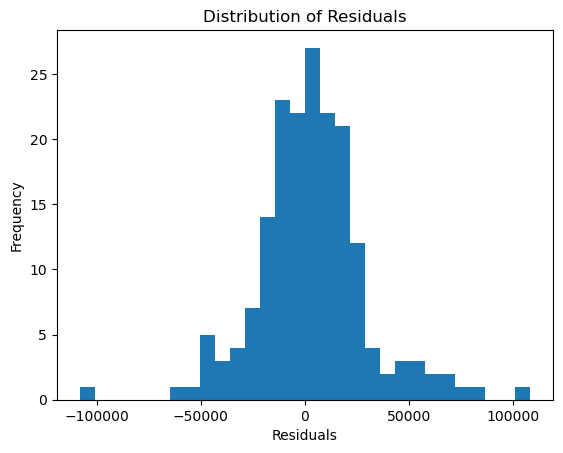

In [23]:
# distribution of residuals
plt.hist(residuals, bins=30)
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Distribution of Residuals")
plt.show()

## Random Forest

In [26]:
# create random forest model
rf = RandomForestRegressor(random_state=42)

# train random forest model
rf.fit(X_train, y_train)

# predict
y_test_pred_rf = rf.predict(X_test)

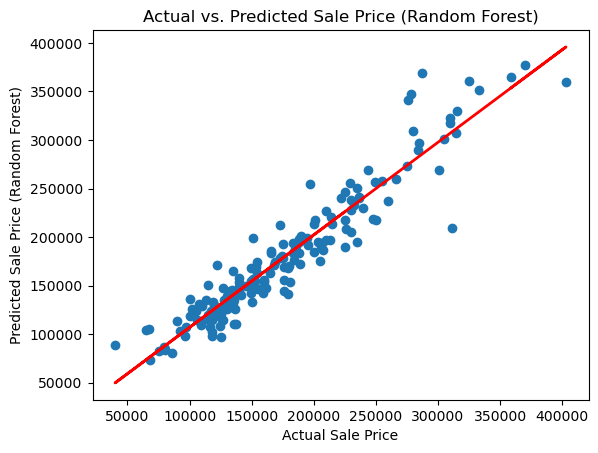

In [27]:
# scatter plot for actual vs. predicted Sale Price
plt.scatter(y_test, y_test_pred_rf)
plt.xlabel("Actual Sale Price")
plt.ylabel("Predicted Sale Price (Random Forest)")
plt.title("Actual vs. Predicted Sale Price (Random Forest)")

# add line of best fit
fit_rf = np.polyfit(y_test, y_test_pred_rf, 1)
line_rf = np.poly1d(fit_rf)
plt.plot(y_test, line_rf(y_test), color="red", linewidth=2)

plt.show()

In [28]:
# r-squared and other metrics for Random Forest
print(f"Random Forest R-squared: {r2_score(y_test, y_test_pred_rf)}")
print(f"Random Forest Mean Squared Error: {mean_squared_error(y_test, y_test_pred_rf)}")
print(f"Random Forest Mean Absolute Error: {mean_absolute_error(y_test, y_test_pred_rf)}")
print(f"Random Forest Mean Percentage Error: {np.mean((y_test - y_test_pred_rf) / y_test) * 100}")

Random Forest R-squared: 0.8969215420814829
Random Forest Mean Squared Error: 447478229.20507044
Random Forest Mean Absolute Error: 14698.426263736264
Random Forest Mean Percentage Error: -3.8002864470701163


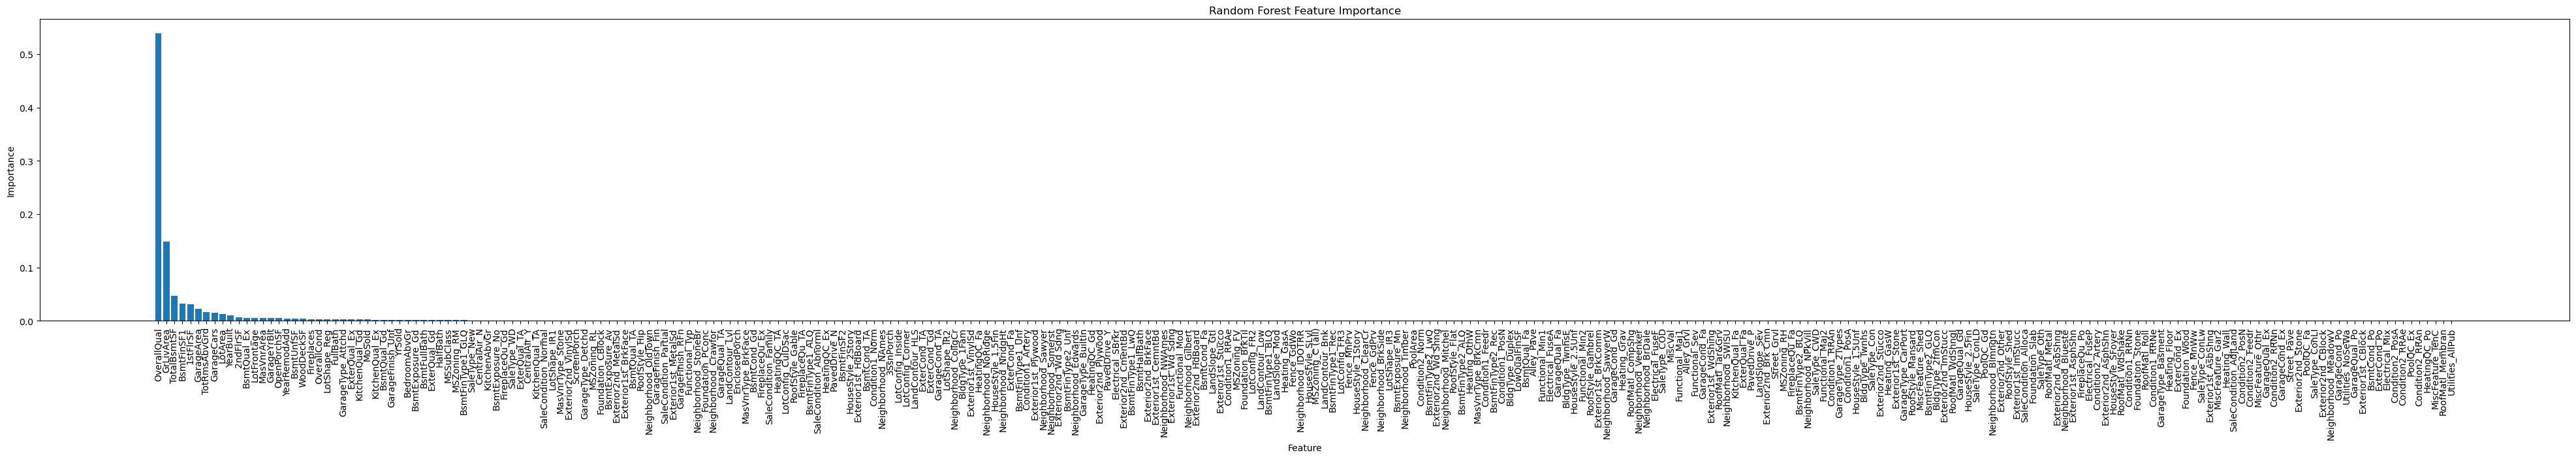

In [31]:
# plot random forest features
feature_importances = rf.feature_importances_

# cdreat df with feature names and importance scores
feature_importance_df = pd.DataFrame({'Feature': dummies.drop(columns="SalePrice").columns, 'Importance': feature_importances})

# sort in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# plot
plt.figure(figsize=(50, 6))
plt.bar(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xticks(rotation=90)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Random Forest Feature Importance')
plt.show()

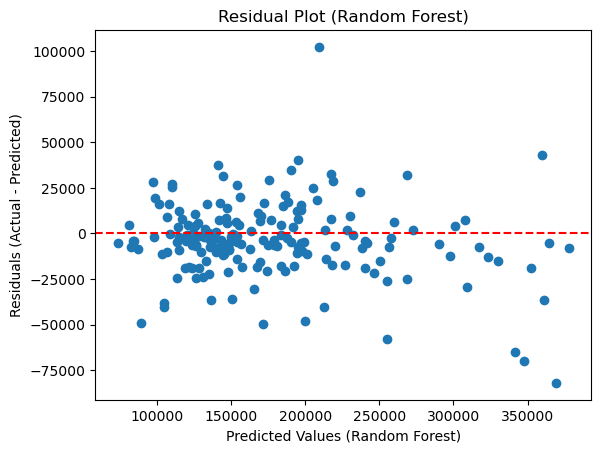

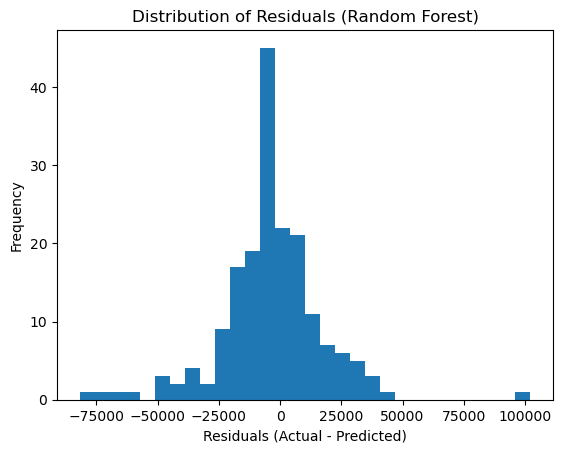

In [30]:
# plot residuals for Random Forest
residuals_rf = y_test - y_test_pred_rf

# scatter plot for residuals
plt.scatter(y_test_pred_rf, residuals_rf)
plt.axhline(y=0, color="r", linestyle="--")
plt.xlabel("Predicted Values (Random Forest)")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title("Residual Plot (Random Forest)")
plt.show()

# distribution of residuals
plt.hist(residuals_rf, bins=30)
plt.xlabel("Residuals (Actual - Predicted)")
plt.ylabel("Frequency")
plt.title("Distribution of Residuals (Random Forest)")
plt.show()